---
* ### Import as libs  
---

In [60]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MaxNLocator
from matplotlib.animation import FuncAnimation, PillowWriter
from simu import *
import cvxpy as cp

---
* ### Função para plotar, printar TF e matriz
---

In [61]:
def plot(time, y_matriz, title="unknown", cols_name="unknown", time_aux=None, y_matriz_aux=None, plot=False, plot_no_cols=None):
    """
    Plota gráficos em grade (n_row x n_col) com estilo mais profissional,
    preservando 100% a lógica original de offsets, step/plot e legendas.
    """
    n_row, n_col = len(y_matriz), len(y_matriz[0])
    y_matriz = y_matriz[::-1]
    if y_matriz_aux is not None:
        y_matriz_aux = y_matriz_aux[::-1]

    # altura = 1 * n_row
    altura = n_row * 1.12

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, n_col, figsize=(11, altura), sharex=True, constrained_layout=True)

        if n_row == 1 and n_col == 1:
            axs = [[axs]]
        elif n_row == 1:
            axs = [axs]
        elif n_col == 1:
            axs = [[ax] for ax in axs]

        for j in range(n_col):
            if cols_name != "unknown":
                axs[0][j].set_title(f'{title} - {cols_name[j]}')

        main_lw = 1.1
        aux_lw = 1.0
        msize = 3

        # encontra o valor de y máximo para ajustar todos os eixos 
        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                if plot_no_cols is not None and j in plot_no_cols:
                    continue
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))
                if y_matriz_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    y_data_aux = dic_aux[0]
                    y_max = max(y_max, np.max(y_data_aux))
                    y_min = min(y_min, np.min(y_data_aux))

        for i in range(n_row):
            for j in range(n_col):
                if plot_no_cols is not None and j in plot_no_cols:
                    axs[i][j].set_visible(False)
                    continue
                ax = axs[i][j]
                ax.set_axisbelow(True)  
                ax.grid(True, which='major', linestyle=':', alpha=0.5)
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
                ax.margins(y=0.1) 
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
                #ymin, ymax = ax.get_ylim()
                ax.set_ylim(y_min * 1.1, y_max * 1.1)

                for side in ["top", "right", "left", "bottom"]:
                    ax.spines[side].set_linewidth(0.8)
                    ax.spines[side].set_alpha(0.6)

                offset_x = 0
                if y_matriz_aux is not None and time_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    offset_x = len(dic_aux[0])
                    if plot:
                        ax.plot(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, markersize=msize, alpha=0.95
                        )
                    else:
                        ax.step(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, where='pre'
                        )

                    # transforma em dt
                    dt = time[1] - time[0]
                    offset_x = offset_x * dt

                # plota as linhas principais
                dic = y_matriz[i][j]
                if plot:
                    ax.plot(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, markersize=msize, alpha=0.98
                    )
                else:
                    ax.step(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, where='pre'
                    )

                leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                                handlelength=1.8, borderaxespad=0.6)
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)

        plt.tight_layout(pad=1.2)
        plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

def print_matriz(mat):
    sp.pprint(mat)
    print()

In [62]:
def plot_1_column(time, y_matriz, title="unknown", cols_name="unknown"):
    n_row, n_col = len(y_matriz), len(y_matriz[0])

    y_matriz = y_matriz[::-1]

    altura = n_row * 1.12

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, 1, figsize=(6, altura),
                                sharex=True, constrained_layout=True)

        if n_row == 1:
            axs = [axs]

        main_lw = 1.1

        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))

        for i in range(n_row):
            ax = axs[i]
            if i == 0:
                ax.set_title(f'{title}')

            ax.set_axisbelow(True)
            ax.grid(True, which='major', linestyle=':', alpha=0.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
            ax.margins(y=0.1)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
            ax.set_ylim(y_min * 1.1, y_max * 1.1)

            for side in ["top", "right", "left", "bottom"]:
                ax.spines[side].set_linewidth(0.8)
                ax.spines[side].set_alpha(0.6)

            for j in range(n_col):
                dic = y_matriz[i][j]
                ax.step(
                    time, dic[0],
                    label=dic[1], color=dic[2], linestyle=dic[3],
                    linewidth=main_lw, where='pre'
                )

            # legenda com todas as curvas daquela linha
            leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                            handlelength=1.8, borderaxespad=0.6)
            leg.get_frame().set_linewidth(0.6)
            leg.get_frame().set_alpha(0.9)

        plt.tight_layout(pad=1.2)
        plt.show()


In [63]:
def plot_ladder_uq(y_matriz, cols_name, x_label):
    
    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        """
        Para a coluna j, retorna uma lista de tuplas:
        (serie_1d, label, color, marker)
        """
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]

            # garante que é array 1D (se vier 2D, achatamos)
            y = np.asarray(dic[0])
            y = np.ravel(y)  # vira 1D
            y = np.abs(y)

            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series
    
    fig, ax = plt.subplots(
        1, 1,
        figsize=(3, 6),
        constrained_layout=True
    )

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):

        # setup do único eixo
        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        # posições y uniformes + rótulos x1..xn
        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get(
            'color', ['C0','C1','C2','C3','C4','C5','C6','C7']
        )
        
        all_vals = []
        handles = []

        for col in range(n_col):
            series = extract_col(col)
            color = palette[col % len(palette)]

            # calcula o ponto de máximo de CADA série
            x_max = []
            for (y, label, color_unused, marker) in series:
                if y.size == 0:
                    x_max.append(0.0)
                else:
                    idx_max = int(np.nanargmax(y))  # índice do máximo
                    valor_max = float(y[idx_max])   # valor máximo
                    x_max.append(valor_max)

            x_max = np.array(x_max, dtype=float)
            all_vals.append(x_max)

            # linha conectando os máximos dessa coluna
            (line_handle,) = ax.plot(
                x_max, y_pos,
                linewidth=1.2,
                alpha=0.9,
                color=color,
                label=str(cols_name[col]) if col < len(cols_name) else f"col {col}",
            )

            # marcadores nos pontos de máximo
            for i, (y, label, color_unused, marker) in enumerate(series):
                ax.plot(
                    [x_max[i]], [y_pos[i]],
                    linestyle='None',
                    marker=marker or 'o',
                    markersize=7.5,
                    markerfacecolor='none',
                    markeredgewidth=1.2,
                    color=color,
                )

            handles.append(line_handle)

        # ajusta limites do eixo x
        if len(all_vals):
            all_vals_flat = np.abs(np.concatenate(all_vals))
            Xmax = float(all_vals_flat.max()) if all_vals_flat.size else 0.0
        else:
            Xmax = 0.0

        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(0, Xpad)

        ax.legend(handles=handles, loc='lower right')

    plt.show()


In [64]:
def plot_ladder_uq_gif(time, y_matriz, x_label="Deslocamento", cols_name=("u","q"), Ts=1):
    
    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]
            y = np.asarray(dic[0])
            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series

    fig, ax = plt.subplots(1, 1, figsize=(3, 6), constrained_layout=True, sharey=True)

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):

        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7'])
        
        all_vals = []
        series_per_col = []
        for col in range(n_col):
            series = extract_col(col)
            series_per_col.append(series)
            col_vals = np.concatenate([np.asarray(s[0]).ravel() for s in series])
            all_vals.append(np.abs(col_vals))

        all_vals = np.concatenate(all_vals) if len(all_vals) else np.array([0.0])
        Xmax = float(all_vals.max()) if all_vals.size else 0.0
        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(-Xpad, Xpad)

        handles = []
        dyn_lines = []
        dyn_points = []
        for col in range(n_col):
            series = series_per_col[col]
            color = palette[col % len(palette)]
            label_col = str(cols_name[col]) if col < len(cols_name) else f"col {col}"

            x_now = np.array([float(s[0][0]) for s in series])

            (line_handle,) = ax.plot(x_now, y_pos, linewidth=1.2, alpha=0.9, color=color, label=label_col)
            pts = []
            for i, (y, label, color_unused, marker) in enumerate(series):
                h = ax.plot([x_now[i]], [y_pos[i]],
                            linestyle='None',
                            marker=marker or 'o',
                            markersize=7.5,
                            markerfacecolor='none',
                            markeredgewidth=1.2,
                            color=color)[0]
                pts.append(h)

            handles.append(line_handle)
            dyn_lines.append(line_handle)
            dyn_points.append(pts)

        ax.legend(handles=handles, loc='lower right')

        T = len(np.asarray(time))
        frames_idx = np.arange(1, T + 1, dtype=int)

        def update(k):
            artists = []
            for col in range(n_col):
                series = series_per_col[col]
                x_now = np.array([float(s[0][k-1]) for s in series])
                dyn_lines[col].set_data(x_now, y_pos)
                artists.append(dyn_lines[col])
                for i, h in enumerate(dyn_points[col]):
                    h.set_data([x_now[i]], [y_pos[i]])
                    artists.append(h)
            return artists

        anim = FuncAnimation(fig, update, frames=frames_idx, blit=True, interval=Ts)
        anim.save("ladder_uq.gif", writer=PillowWriter(fps=15))

    print("Animação salva como 'ladder_uq.gif'.")
    plt.close()

---
* ### Constantes
---

In [65]:
import numpy as np

# -----------------------------
#       Dados do artigo (adicionei um k e c para o ATMD senao ele vai pro infinito)
# -----------------------------

n_node = 6
m_amd_ton = 0.175                                                   # [t]
m_ton  = np.array([2.16, 2.34, 2.25, 2.18, 2.56, 2.52, m_amd_ton])      # [t]
k_kN_m = np.array([555, 504, 407, 316, 221, 102, 75])               # [kN/m]
c_kNs_m= np.array([3.26, 8.20, 4.72, 4.16, 3.18, 1.54, 0.9])       # [kNs/m]

# Ajustei o ganho só pra plotar
ton_to_kg   = 1e-3
kN_to_N     = 1e-3
kNs_to_Ns   = 1e-3

m_arr  = (m_ton * ton_to_kg).tolist()
k_arr = (k_kN_m * kN_to_N).tolist()
c_arr = (c_kNs_m * kNs_to_Ns).tolist()

'''n_node = 4

# massas
coef_m = 0.5
ATMD_m = 2.5
m_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]

coef_k = 1.0
ATMD_k = 0.5
k_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]

u_idx_list = [4, 5]        
k_arr = [ (2.0*k if (idx+1) in u_idx_list else k) for idx, k in enumerate(k_arr) ]

zeta_star = 0.7
import math
c_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]

beta_0 = 0.0033'''


'n_node = 4\n\n# massas\ncoef_m = 0.5\nATMD_m = 2.5\nm_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]\n\ncoef_k = 1.0\nATMD_k = 0.5\nk_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]\n\nu_idx_list = [4, 5]        \nk_arr = [ (2.0*k if (idx+1) in u_idx_list else k) for idx, k in enumerate(k_arr) ]\n\nzeta_star = 0.7\nimport math\nc_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]\n\nbeta_0 = 0.0033'

---
* ### Matrizes
---

In [66]:
# ATMD variaveis 
c_and_coef = True
offset = 1 if c_and_coef else 2

# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr) - offset):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr) - offset):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz de perturbação
C = -m_matriz @ sp.Matrix([[1] for _ in range(n_node + 1)])

---
* ### Funções de transferência
---

In [67]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz

# Função de transferência do sistema
H_U = A.inv() * B
H_Q = A.inv() * C

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [68]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                                                                         -1.38e-16 s^7 - 4.959e-14 s^6 - 7.103e-12 s^5 - 5.07e-10 s^4 - 1.803e-08 s^3 - 2.557e-07 s^2
  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  2.799e-20 s^14 + 7.304e-19 s^13 + 6.52e-17 s^12 + 1.187e-15 s^11 + 5.423e-14 s^10 + 6.841e-13 s^9 + 2.064e-11 s^8 + 1.711e-10 s^7 + 3.752e-09 s^6 + 1.822e-08 s^5 + 3.06e-07 s^4 + 6.915e-07 s^3 + 9.281e-06 s^2 + 5.376e-06 s + 6.082e-05

                  -2.799e-20 s^12 - 6.881e-19 s^11 - 5.713e-17 s^10 - 9.643e-16 s^9 - 4.065e-14 s^8 - 4.614e-13 s^7 - 1.272e-11 s^6 - 8.978e-11 s^5 - 1.78e-09 s^4 - 6.575e-09 s^3 - 9.931e-08 s^2 - 1.283e-07 s - 1.555e-06
  ----------------------------------------------------------------------------------------------------------------------------------------

---
* ### Matriz de TF - sistema discreto
---

In [69]:
# tempo de amostragem 
T = 0.1

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

  -1.228e-06 z^13 - 0.0004541 z^12 - 0.009975 z^11 - 0.04332 z^10 - 0.02685 z^9 + 0.08129 z^8 + 0.07829 z^7 - 0.02572 z^6 - 0.04158 z^5 - 0.01101 z^4 - 0.0006682 z^3 + 3.697e-06 z^2 - 4.529e-08 z + 8.63e-11
  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
             z^14 - 1.447 z^13 + 1.652 z^12 - 1.596 z^11 + 1.604 z^10 - 1.239 z^9 + 0.9545 z^8 - 0.574 z^7 + 0.4258 z^6 - 0.1576 z^5 + 0.1571 z^4 - 0.03507 z^3 + 0.1523 z^2 + 0.08782 z + 0.07357

  -0.003982 z^13 - 0.0007785 z^12 - 0.002852 z^11 - 0.001435 z^10 - 0.002576 z^9 - 0.002438 z^8 - 0.001964 z^7 - 0.002562 z^6 - 0.00181 z^5 - 0.002148 z^4 - 0.001729 z^3 - 0.001624 z^2 - 0.0008069 z - 0.0003101
  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Plot - resposta ao impulso
---

In [70]:
# dados pra simular
start = 0
stop = 15
step = T
step_continuo = 0.01
time = np.arange(start, stop, step)
time_continuo = np.arange(start, stop, step_continuo)

cols_name = ['u', 'q']

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_6736\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


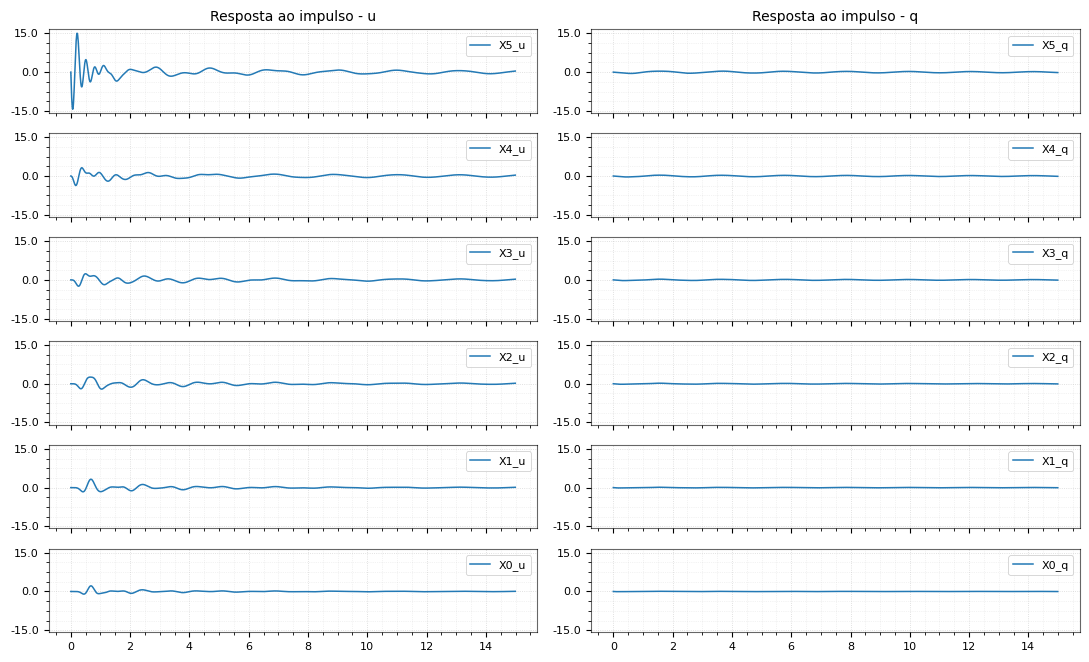

In [71]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time_continuo)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time_continuo, y_matriz_out[:-1], "Resposta ao impulso", cols_name, plot=True)

---
* ### Plot - resposta ao impulso
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_6736\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


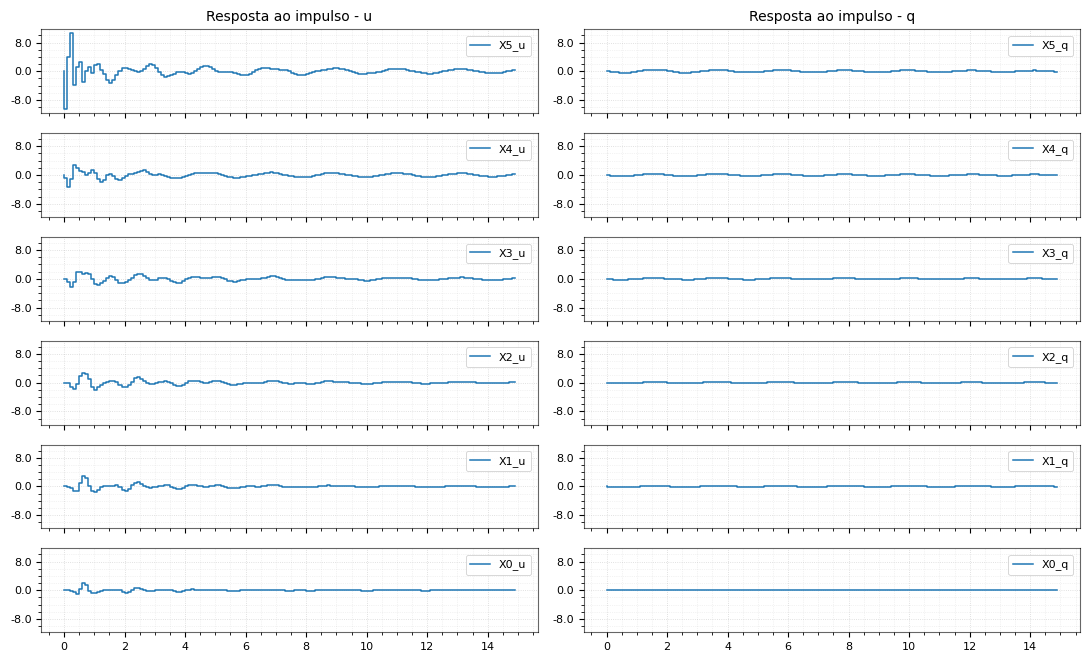

In [72]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = H_z_matriz[i][j].impulse_response(T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out[:-1], "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_6736\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


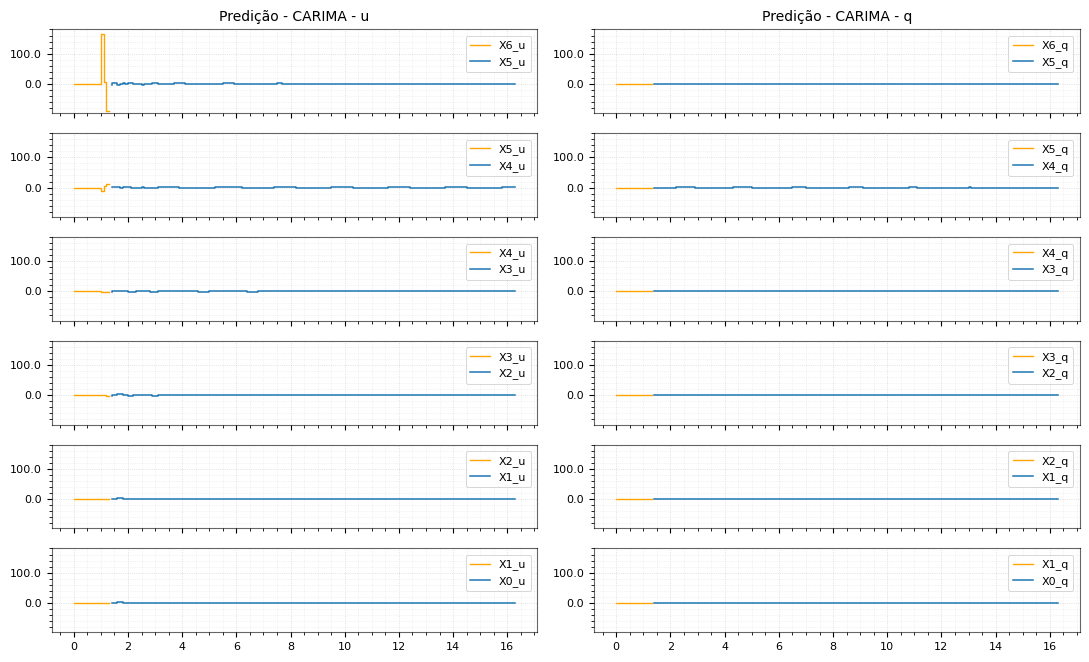

In [ ]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]
x_free = [[] for _ in range(H.rows)]

# quantidade de pontos como condição inicial
past = 3

for i in range(H.rows):
    for j in range(H.cols):
        F, G, M = generate_matrices(H_z_matriz[i][j], N_u=1, N=len(time), Ts=T)
        # matriz de past pra inicializar
        init = [0] * (F.shape[1] - past)
        perturbation = [0] * M.shape[1]
        perturbation[past-1 if past > 0 else 0] = 1 # feedfoward
        y_feedfoward = M @ perturbation
        
        # pegar a condição inicial e concate com past
        y_in =  y_matriz_out[i][j][0][1:past+1][::-1] + init

        # calcula a resposta livre
        y_out = F @ y_in
        y_out += y_feedfoward
        if j == 1:
            x_free[i].append(y_out.tolist())

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', None]
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot - menos a coluna 1 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

---
* ### função custo minizando apenas xn (nacele)
---

In [74]:
# ponderação nas ações de controle
'''alpha = 0.01
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G, M = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y, Ts=T)

# solution of quadratic problem
K = np.linalg.inv(G.T @ Q @ G + R) @ G.T

# solucao do sistema (free para a massa da nacele)
x0_free = y_pred[n_node-1][1][0].copy()
u_opt = -K @ x0_free

# calcula a resposta forçada para todos os x 
y_controled = [[] for _ in range(H.rows)]

for i in range(H.rows):
        j = 0
        H_ij = H_z_matriz[i][j]
        y_free = y_pred[i][1][0]
        F_ij, G_ij, Mij = generate_matrices(H_ij, N_u, N_y, Ts=T)
        y_forced = G_ij @ u_opt
        y_total = y_free + y_forced
        y_plot1 = [y_total, "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_controled[i].append(y_plot1)

# plot
plot(time, y_controled, "Resposta forçada - CARIMA", cols_name)'''
#plot_ladder_uq(time, y_controled[:-1], col_name=cols_name, x_label="deslocamento")
#plot_ladder_uq_gif(time[:-10], y_controled[:-1], col_name=cols_name, x_label="Deslocamento máximo com controle [m]")

'alpha = 0.01\nN_y = len(time)\nN_u = len(time)\n\nR = np.eye(N_u) * alpha\nQ = np.eye(N_u) # monovariavel - delta é fixo = 1\n\nF, G, M = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y, Ts=T)\n\n# solution of quadratic problem\nK = np.linalg.inv(G.T @ Q @ G + R) @ G.T\n\n# solucao do sistema (free para a massa da nacele)\nx0_free = y_pred[n_node-1][1][0].copy()\nu_opt = -K @ x0_free\n\n# calcula a resposta forçada para todos os x \ny_controled = [[] for _ in range(H.rows)]\n\nfor i in range(H.rows):\n        j = 0\n        H_ij = H_z_matriz[i][j]\n        y_free = y_pred[i][1][0]\n        F_ij, G_ij, Mij = generate_matrices(H_ij, N_u, N_y, Ts=T)\n        y_forced = G_ij @ u_opt\n        y_total = y_free + y_forced\n        y_plot1 = [y_total, "X{}_{}".format(i, cols_name[j]), \'C0\', None]\n        y_controled[i].append(y_plot1)\n\n# plot\nplot(time, y_controled, "Resposta forçada - CARIMA", cols_name)'

---
* ### funcao custo minimizando todos os x
---

In [75]:
N_u = 30
N_y = 30

alpha_list = 0.01
R_list = np.eye(N_u) * alpha_list
Q_list = np.eye(N_y * n_node)
delta_arr = [0.1**i for i in range(n_node)]
delta_arr[-1] = 100  # maior peso pra massa da nacele
for i in range(n_node):
    start_idx = i * N_y
    end_idx = start_idx + N_y
    Q_list[start_idx:end_idx, start_idx:end_idx] = np.eye(N_y) * delta_arr[n_node - 1 - i]

# empilhas todas as matrizes 
G_list = []
F_list = []
M_list = []
M_q_list = []
G_q_list = []

for i in range(H.rows-1):
    F_i, G_i, M_i = generate_matrices(H_z_matriz[i][0], N_u, N_y, Ts=T)
    G_list.append(G_i)
    F_list.append(F_i)
    M_list.append(M_i)
    
    lixo1, G_q, M_q = generate_matrices(H_z_matriz[i][1], N_y, N_y, Ts=T)
    M_q_list.append(M_q)
    G_q_list.append(G_q)

# retura as ultimas N_y linhas
G_list = np.vstack(G_list)

# solution of quadratic problem
K_list = np.linalg.inv(G_list.T @ Q_list @ G_list + R_list) @ G_list.T @ Q_list


In [76]:
# controled_total = [y_controled, y_controled_2]
'''y_controled_total = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols + 1):
        if j == 0:
            y_controled_total[i].append(y_controled[i][0])
        elif j == 1:
            y_controled_total[i].append(y_controled_2[i][0])
        else:
            y_controled_total[i].append(y_matriz_out[i][1])
# plot  
plot_ladder_uq(time, y_controled_total[:-1], x_label="Deslocamento Máximo [µm]", cols_name=["controle x_0", "controle_x", "Malha Aberta"])'''
#plot_ladder_uq_gif(time[:-10], y_controled[:-1], col_name=cols_name, x_label="Deslocamento máximo com controle [m]")

'y_controled_total = [[] for _ in range(H.rows)]\nfor i in range(H.rows):\n    for j in range(H.cols + 1):\n        if j == 0:\n            y_controled_total[i].append(y_controled[i][0])\n        elif j == 1:\n            y_controled_total[i].append(y_controled_2[i][0])\n        else:\n            y_controled_total[i].append(y_matriz_out[i][1])\n# plot  \nplot_ladder_uq(time, y_controled_total[:-1], x_label="Deslocamento Máximo [µm]", cols_name=["controle x_0", "controle_x", "Malha Aberta"])'

In [77]:
#plot_ladder_uq_gif(time, y_controled_total[:-1], x_label="Deslocamento [µm]", cols_name=["controle x_0", "controle_x", "Malha Aberta"], Ts=T/10)

Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optima

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_6736\609284571.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


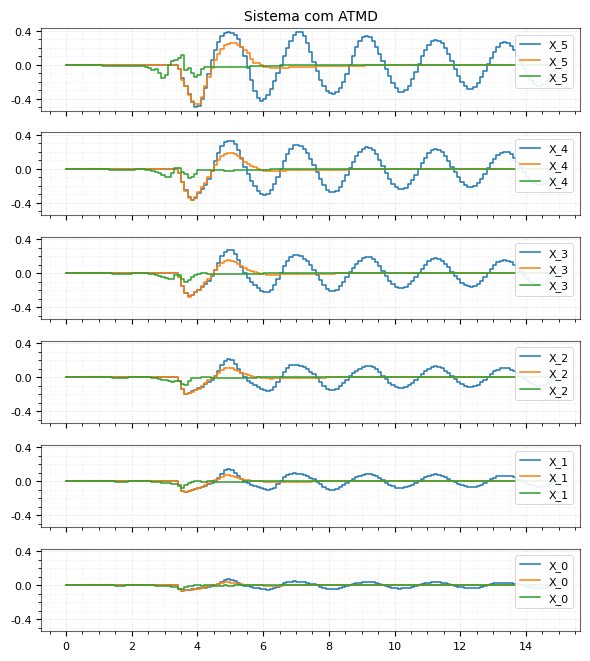

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_6736\609284571.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


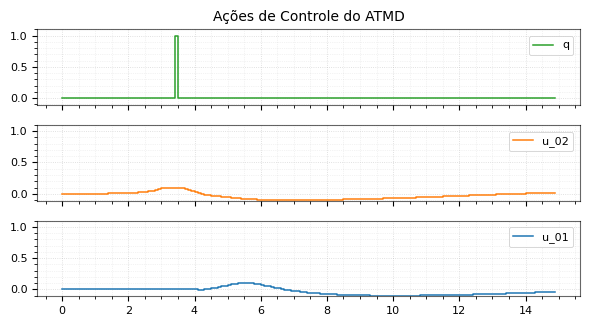

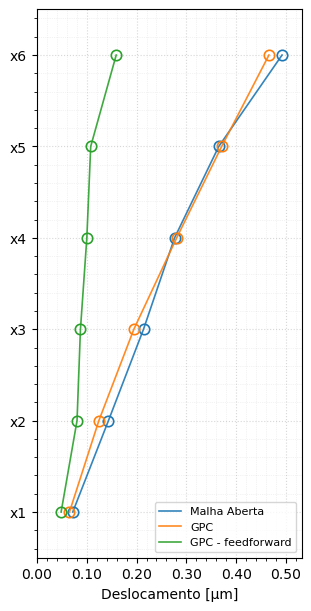

Animação salva como 'ladder_uq.gif'.


In [78]:
# limites de saturação do atuador
u_min = -0.1
u_max =  0.1

# configuracao pro otimizador 
precisao = 1e-6
interacoes = 100000

# salva os resultados da simulação para plotar  
y_arr = [[[[], "X_{}".format(j), 'C0', None], 
          [[], "X_{}".format(j), 'C1', None],
          [[], "X_{}".format(j), 'C2', None]] for j in range(n_node)]

# salva u_01, u_02 e q 
u_arr = [[[[], "u_01", 'C0', None]],
         [[[], "u_02", 'C1', None]],
         [[[], "q", 'C2', None]]]

plant_arr_1 = []
plant_arr_2 = []
plant_arr_ma = []

for i in range(H.rows):
    H_u = H_z_matriz[i][0]
    H_q = H_z_matriz[i][1]

    # controle sem feedfoward
    plant_ij = Plant(H_u, H_q)
    plant_arr_1.append(plant_ij)  
    
    # controle com feedfoward
    plant_1 = Plant(H_u, H_q)
    plant_arr_2.append(plant_1)

    # malha aberta
    plant_2 = Plant(H_u, H_q)
    plant_arr_ma.append(plant_2)    

# matriz H da funcao quadratica
H_local = 2 * (G_list.T @ Q_list @ G_list + R_list)

# acao de controle
u_opt_matr_1 = 0.0
u_opt_matr_2 = 0.0

# array de perturbacao para todo periodo de tempo
perturbation = [0] * (len(time)+N_y)
perturbation[N_y + 5] = 1 # instante q dou um impulso na perturbacao

for i in range(len(time)):
    # array de predição
    predictions = []
    predictions_feedfoward = []

    # simula todos os nos
    for j in range(H.rows-1):
        # aplica a perturbação e pega valores futuros
        q = perturbation[i if i > 0 else 0]
        q_future = np.array((perturbation[i:i+N_y]))

        # roda a simulacao da planta
        y_ma = plant_arr_ma[j].step(0, q)
        y_01 = plant_arr_1[j].step(u_opt_matr_1, q)
        y_02 = plant_arr_2[j].step(u_opt_matr_2, q)

        # pega as condicoes iniciais
        '''y_pastma = plant_arr_ma[j].y_past()
        u_pastma = plant_arr_ma[j].u_past()
        q_pastma = plant_arr_ma[j].q_past()'''
        
        y_past1 = plant_arr_1[j].y_past()
        u_past1 = plant_arr_1[j].u_past()
        q_past1 = plant_arr_1[j].q_past()

        y_past2 = plant_arr_2[j].y_past()
        u_past2 = plant_arr_2[j].u_past()
        q_past2 = plant_arr_2[j].q_past()

        # predição com feedfoward
        y_feedfoward = F_list[j] @ y_past2 + M_list[j] @ u_past2 + M_q_list[j] @ q_past2 + G_q_list[j] @ q_future

        # predição sem feedfoward
        pred = F_list[j] @ y_past1 + M_list[j] @ u_past1

        # salva a predição em um array
        predictions.append(pred)
        predictions_feedfoward.append(y_feedfoward)

        # salva os resultados pra plotar
        y_arr[j][0][0].append(y_ma)
        y_arr[j][1][0].append(y_01)
        y_arr[j][2][0].append(y_02)

    # transforma em vetor para o cvxpy
    predictions = np.asarray(predictions).flatten()
    predictions_feedfoward = np.asarray(predictions_feedfoward).flatten()

    # solucao analitica (sem saturação)
    #u_unconstrained = -K_list @ predictions

    # variaveis de otimizacao
    u_var_1 = cp.Variable(N_u)
    u_var_2 = cp.Variable(N_u)

    # custo: 0.5*u'Hu + c'u
    c1 = 2 * -(G_list.T @ Q_list @ -predictions)
    c2 = 2 * (G_list.T @ Q_list @ predictions_feedfoward)
    cost1 = 0.5 * (u_var_1.T @ H_local @ u_var_1) + c1.T @ u_var_1
    cost2 = 0.5 * (u_var_2.T @ H_local @ u_var_2) + c2.T @ u_var_2

    # função objetivo
    objective1 = cp.Minimize(cost1)
    objective2 = cp.Minimize(cost2)

    # restrições de saturação
    constraints1 = [
        u_var_1 <= u_max,
        u_var_1 >= u_min
    ]
    constraints2 = [
        u_var_2 <= u_max,
        u_var_2 >= u_min
    ]

    # problema para minimização
    prob1 = cp.Problem(objective1, constraints1)
    prob2 = cp.Problem(objective2, constraints2)

    prob1.solve(
        solver=cp.OSQP,
        eps_abs=precisao,
        eps_rel=precisao,
        max_iter=interacoes,
        polish=True,
        verbose=False
    )
    prob2.solve(
        solver=cp.OSQP,
        eps_abs=precisao,
        eps_rel=precisao,
        max_iter=interacoes,
        polish=True,
        verbose=False
    )

    # salva a ação de controle para plotar
    u_arr[0][0][0].append(u_opt_matr_1)
    u_arr[1][0][0].append(u_opt_matr_2)
    u_arr[2][0][0].append(q)

    # pega a primeira ação de controle
    u_opt_matr_1 = u_var_1.value[0]
    u_opt_matr_2 = u_var_2.value[0]

    # saturação
    u_opt_matr_1 = max(min(u_opt_matr_1, u_max), u_min)
    u_opt_matr_2 = max(min(u_opt_matr_2, u_max), u_min)
       
plot_1_column(time, y_arr, "Sistema com ATMD")
plot_1_column(time, u_arr, "Ações de Controle do ATMD")
plot_ladder_uq(y_arr, x_label="Deslocamento [µm]", cols_name=["Malha Aberta", "GPC", "GPC - feedforward"])
plot_ladder_uq_gif(time, y_arr, x_label="Deslocamento [µm]", cols_name=["Malha Aberta", "GPC", "GPC - feedforward"])